## ======================
**** Outputs:

ARIMA (pure statsmodels) 6M & 12M forecasts with 95% CIs

LSTM 6M & 12M forecasts; uncertainty bands via Monte-Carlo Dropout (approximate)

Side-by-side plots + metrics + commentary hooks

Assumptions:

We used the Task-2 split: train ≤ 2023-12-31, test = 2024-01-01 → 2025-07-31.

We modeled Adj Close as price.****
## ==========================

# Setup & data

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings, datetime as dt
warnings.filterwarnings("ignore")

import yfinance as yf
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Deep learning (for LSTM uncertainty)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from statsmodels.tsa.arima.model import ARIMA

plt.rcParams['figure.figsize'] = (11,6)
plt.rcParams['axes.grid'] = True

TICKER = "TSLA"
START  = "2015-07-01"
END    = "2025-07-31"

raw = yf.download(TICKER, start=START, end=END, auto_adjust=False)
df = raw[['Adj Close']].rename(columns={'Adj Close':'price'}).dropna()

train_end = "2023-12-31"
test_start = "2024-01-01"
train = df.loc[:train_end].copy()
test  = df.loc[test_start:].copy()

print("Data range:", df.index.min().date(), "→", df.index.max().date(), "obs:", len(df))
print("Train:", train.index.min().date(), "→", train.index.max().date(), "n=", len(train))
print("Test :", test.index.min().date(),  "→", test.index.max().date(),  "n=", len(test))


[*********************100%***********************]  1 of 1 completed

Data range: 2015-07-01 → 2025-07-30 obs: 2535
Train: 2015-07-01 → 2023-12-29 n= 2140
Test : 2024-01-02 → 2025-07-30 n= 395


# ARIMA: fit (or reuse) and forecast 6M/12M 

In [2]:
# Small grid search for (p,d,q) by AIC (no pmdarima required)
best_aic, best_order, best_model = np.inf, None, None
for p in range(0,4):
    for d in range(0,3):
        for q in range(0,4):
            try:
                m = ARIMA(train['price'], order=(p,d,q)).fit()
                if m.aic < best_aic:
                    best_aic, best_order, best_model = m.aic, (p,d,q), m
            except:
                pass
print("ARIMA best order:", best_order, "AIC:", round(best_aic,2))


d:\10acadamy\server-inventory-app\W11-Time_Series_Forecasting_PMO\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\10acadamy\server-inventory-app\W11-Time_Series_Forecasting_PMO\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\10acadamy\server-inventory-app\W11-Time_Series_Forecasting_PMO\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\10acadamy\server-inventory-app\W11-Time_Series_Forecasting_PMO\venv\Lib\site-packages\statsmodels\ts

ARIMA best order: (3, 1, 2) AIC: 13613.09


d:\10acadamy\server-inventory-app\W11-Time_Series_Forecasting_PMO\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\10acadamy\server-inventory-app\W11-Time_Series_Forecasting_PMO\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


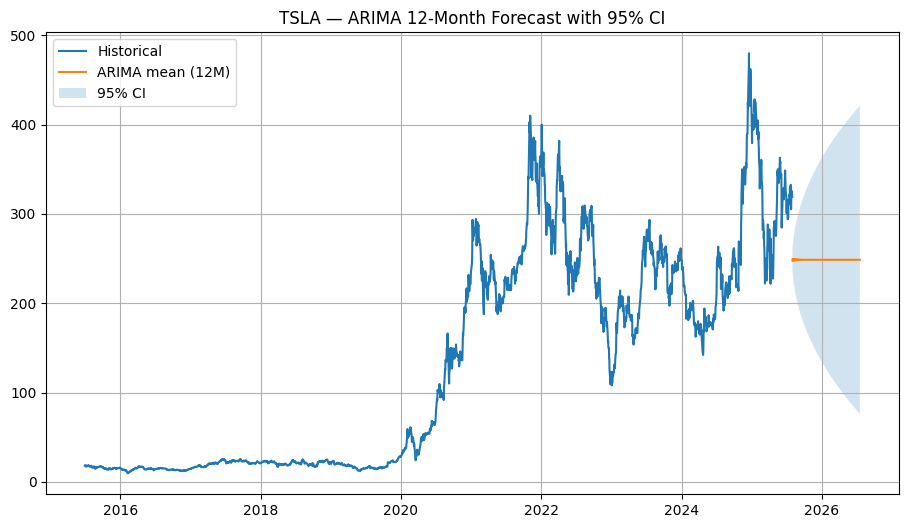

In [3]:
# Forecast horizons in trading days (~21 days/month)
h6  = 21*6    # ~126
h12 = 21*12   # ~252

fc6  = best_model.get_forecast(steps=h6)
fc12 = best_model.get_forecast(steps=h12)

arima_mean_6  = pd.Series(fc6.predicted_mean,  name='ARIMA_6M')
arima_ci_6    = fc6.conf_int(alpha=0.05).rename(columns={'lower price':'lower','upper price':'upper'}).set_axis(['lower','upper'], axis=1)
arima_mean_12 = pd.Series(fc12.predicted_mean, name='ARIMA_12M')
arima_ci_12   = fc12.conf_int(alpha=0.05).rename(columns={'lower price':'lower','upper price':'upper'}).set_axis(['lower','upper'], axis=1)

# Build future date index continuing business days from last known date
last_date = df.index[-1]
future_idx_6  = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=h6)
future_idx_12 = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=h12)

arima_mean_6.index  = future_idx_6
arima_ci_6.index    = future_idx_6
arima_mean_12.index = future_idx_12
arima_ci_12.index   = future_idx_12

# Plot 12M (shows 6M as the first half)
plt.plot(df.index, df['price'], label='Historical')
plt.plot(arima_mean_12.index, arima_mean_12.values, label='ARIMA mean (12M)')
plt.fill_between(arima_ci_12.index, arima_ci_12['lower'], arima_ci_12['upper'], alpha=0.2, label='95% CI')
plt.title('TSLA — ARIMA 12-Month Forecast with 95% CI')
plt.legend()
plt.show()


# LSTM: reuse model (if you trained it) or fit quickly, then forecast + uncertainty via MC-Dropout

In [4]:
# ---- Prepare scaling and windowing
lookback = 60
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[['price']])
scaled_all   = scaler.transform(df[['price']])

def make_sequences(series, lb):
    X, y = [], []
    for i in range(lb, len(series)):
        X.append(series[i-lb:i, 0])
        y.append(series[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(scaled_train, lookback)
X_train = X_train[..., np.newaxis]

# ---- (Re)build LSTM if not in memory
def build_lstm(hidden=64, dropout=0.2):
    model = keras.Sequential([
        layers.Input(shape=(lookback,1)),
        layers.LSTM(hidden, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(hidden),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return model

try:
    lstm
except NameError:
    lstm = build_lstm()
    es = keras.callbacks.EarlyStopping(monitor='loss', patience=6, restore_best_weights=True)
    lstm.fit(X_train, y_train, epochs=40, batch_size=64, shuffle=False, callbacks=[es], verbose=0)


# Deterministic LSTM forecast (mean path)

In [5]:
def lstm_forecast_steps(model, last_window_scaled, steps, training_flag=False, n_samples=1):
    """
    Recursive multi-step forecast.
    If training_flag=True and n_samples>1 -> MC Dropout samples.
    Returns array shape (n_samples, steps).
    """
    samples = []
    for s in range(n_samples):
        w = last_window_scaled.copy()
        preds = []
        for _ in range(steps):
            x = w.reshape(1, lookback, 1)
            # call model with training flag to activate dropout if requested
            yhat = model(x, training=training_flag).numpy().flatten()[0]
            preds.append(yhat)
            w = np.append(w[1:], yhat)  # roll window
        samples.append(preds)
    return np.array(samples)

# starting window: last lookback points from ALL data (ends at 2025-07-31)
last_window = scaler.transform(df[['price']]).flatten()[-lookback:]

steps6, steps12 = h6, h12

# Deterministic path
lstm_scaled_path_6  = lstm_forecast_steps(lstm, last_window, steps6, training_flag=False, n_samples=1)[0]
lstm_scaled_path_12 = lstm_forecast_steps(lstm, last_window, steps12, training_flag=False, n_samples=1)[0]

lstm_path_6  = scaler.inverse_transform(lstm_scaled_path_6.reshape(-1,1)).flatten()
lstm_path_12 = scaler.inverse_transform(lstm_scaled_path_12.reshape(-1,1)).flatten()

future_idx_6  = pd.bdate_range(df.index[-1] + pd.Timedelta(days=1), periods=steps6)
future_idx_12 = pd.bdate_range(df.index[-1] + pd.Timedelta(days=1), periods=steps12)

lstm_mean_6  = pd.Series(lstm_path_6,  index=future_idx_6,  name='LSTM_6M')
lstm_mean_12 = pd.Series(lstm_path_12, index=future_idx_12, name='LSTM_12M')


# LSTM uncertainty via Monte-Carlo Dropout 

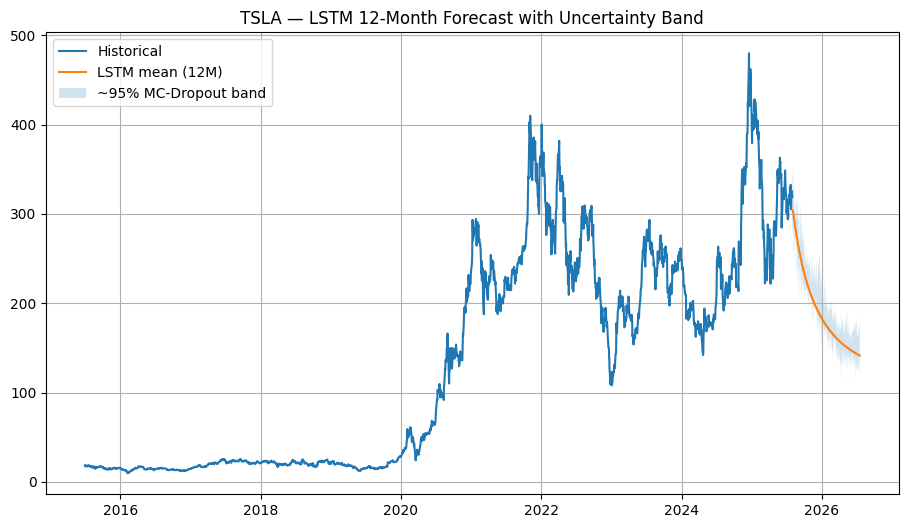

In [8]:
MC_SAMPLES = 5  # increase for smoother bands
mc_scaled_12 = lstm_forecast_steps(lstm, last_window, steps12, training_flag=True, n_samples=MC_SAMPLES)
# invert scale for all samples
mc_12 = np.stack([scaler.inverse_transform(s.reshape(-1,1)).flatten() for s in mc_scaled_12])

lstm_lo_12 = np.percentile(mc_12, 2.5, axis=0)
lstm_hi_12 = np.percentile(mc_12, 97.5, axis=0)

# 6M subset
mc_6 = mc_12[:, :steps6]
lstm_lo_6 = np.percentile(mc_6, 2.5, axis=0)
lstm_hi_6 = np.percentile(mc_6, 97.5, axis=0)

# Plot 12M LSTM with bands
plt.plot(df.index, df['price'], label='Historical')
plt.plot(lstm_mean_12.index, lstm_mean_12.values, label='LSTM mean (12M)')
plt.fill_between(lstm_mean_12.index, lstm_lo_12, lstm_hi_12, alpha=0.2, label='~95% MC-Dropout band')
plt.title('TSLA — LSTM 12-Month Forecast with Uncertainty Band')
plt.legend()
plt.show()


# Side-by-side visualization (ARIMA vs LSTM, 12M)

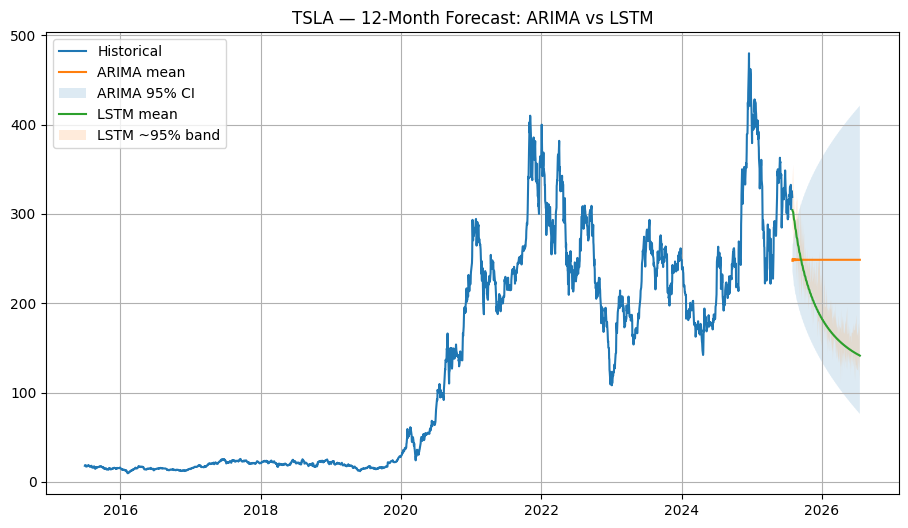

In [9]:
plt.plot(df.index, df['price'], label='Historical')
plt.plot(arima_mean_12.index, arima_mean_12.values, label='ARIMA mean')
plt.fill_between(arima_ci_12.index, arima_ci_12['lower'], arima_ci_12['upper'], alpha=0.15, label='ARIMA 95% CI')
plt.plot(lstm_mean_12.index, lstm_mean_12.values, label='LSTM mean')
plt.fill_between(lstm_mean_12.index, lstm_lo_12, lstm_hi_12, alpha=0.15, label='LSTM ~95% band')
plt.title('TSLA — 12-Month Forecast: ARIMA vs LSTM')
plt.legend()
plt.show()
